В данном блокноте мы рассмотрим построение "карт глубин" для двух синхронных изображений средствами библиотек языка Python.

Допустим, что у нас есть набор синхронных снимков с двух камер. Для того, чтобы получить карты глубин хорошего качества, нужны две абсолютно идентичные камеры (вертикальные и оптические оси параллельны, а горизонтальные оси совпадают). Для каждой такой синхронной пары будем "вытаскивать объем". Воспользуемся тем фактом, что чем ближе объект к камере, тем сильнее будет отличаться его изображение на левом и правом изображениях. Расстояние смещения называется disparity. Чем выше это значение, тем ближе объект к камере.

Наборы таких снимков можно взять, например, на https://vision.middlebury.edu/stereo/data/.

Загружаем библиотеки:

**НЕПРАВИЛЬНО РАБОТАЕТ ЛОКАЛЬНО, НУЖНО СМОТРЕТЬ В КОЛЛАБЕ!!!**

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

In [22]:
# Скачаем пару изображений
!gdown -qq --id 1gIf-gEYeSZ73HSDW4k_SYTaHoP7gSdyv
!gdown -qq --id 1Nd6Exxmjeg7HCDok52vrXFvTd3sz8BcV

/Users/maxim.bulygin/opt/anaconda3/envs/biomedical-images/lib/python3.8/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/Users/maxim.bulygin/opt/anaconda3/envs/biomedical-images/lib/python3.8/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


Считываем левое и правое изображения:

In [24]:
# imgL = cv2.imread("view0.png", cv2.IMREAD_GRAYSCALE)  # левое изображение
# imgR = cv2.imread("view1.png",cv2.IMREAD_GRAYSCALE)  # правое изображение

imgL = cv2.imread("Bowling2_Left.png", cv2.IMREAD_GRAYSCALE)  # левое изображение
imgR = cv2.imread("Bowling2_Right.png",cv2.IMREAD_GRAYSCALE)  # правое изображение

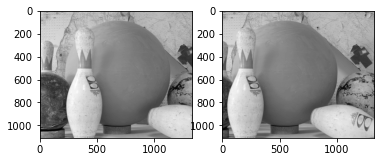

In [25]:
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(imgL, 'gray')
plt.subplot(1,2,2)
plt.imshow(imgR, 'gray')

У нас нет данных камер (фокусного расстояния, расстояния между камерами, расстояния до объекта и т.д.), поэтому мы будем использовать следующий алгоритм: найдем несколько хорошо подобранных точек на обоих изображениях, по ним вычислим фундаментальную матрицу (матрицу преобразования одного изображения в другое), применим ее к нашим изображениям. После этого останется только вычислить диспропорцию (карту глубины) с помощью соответствующих функций.

Находим ключевые точки и дискрипторы (более подробно эта тема рассматривалась в курсе обработки изображений).

In [26]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(imgL, None)
kp2, des2 = orb.detectAndCompute(imgR, None)
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,table_number=6, key_size=12, multi_probe_level=1)  
search_params = dict(checks=50) 
flann = cv2.FlannBasedMatcher(index_params, search_params)
flann_match_pairs = flann.knnMatch(des1, des2, k=2) # Р±РµСЂРµРј 2 РЅР°РёР»СѓС‡С€РёС… СЃРѕРІРїР°РґРµРЅРёСЏ РґР»СЏ РєР°Р¶РґРѕР№ РєРѕРЅС‚СЂРѕР»СЊРЅРѕР№ С‚РѕС‡РєРё
#flann_match_pairs = [match for match in flann_match_pairs if len(match) == 2]

Будем игнорировать неоднозначные соответствия:

In [27]:
filtered_matches = []
ratio_threshold=0.4
for m, n in flann_match_pairs:
  if m.distance < ratio_threshold * n.distance:
    filtered_matches.append(m)

Нарисуем найденные соответствия (выведем лучшие 10):

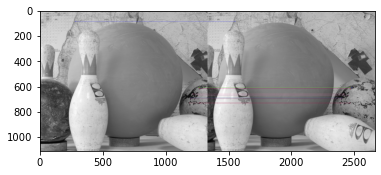

In [28]:
img = cv2.drawMatches(imgL,kp1,imgR,kp2,filtered_matches[:10],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img)

Найдем фундаментальную матрицу из соответствующих контрольных точек, используя метод RANSAC

In [29]:
pts1, pts2 = [], []
fundamental_matrix, inliers = None, None
for m in filtered_matches[:10]:
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)
if pts1 and pts2:
    fundamental_matrix, inliers = cv2.findFundamentalMat(np.float32(pts1), np.float32(pts2), cv2.FM_RANSAC)

Выполняем ректификацию — устанавливаем соответствие между эпиполярными линиями на стереопаре, вдоль которых будет выполняться поиск в ходе работы алгоритма стереосопоставления.

In [30]:
h1, w1 = imgL.shape
h2, w2 = imgR.shape
thresh = 0
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1), threshold=thresh)

Исправляем искажения с помощью полученных матриц H1, H2:

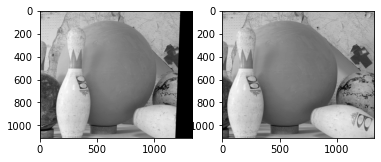

In [31]:
imgL_undistorted = cv2.warpPerspective(imgL, H1, (w1, h1))
imgR_undistorted = cv2.warpPerspective(imgR, H2, (w2, h2))
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
dmObject = plt.imshow(imgL_undistorted, 'gray')
plt.subplot(1,2,2)
dmObject = plt.imshow(imgR_undistorted, 'gray')

Осталось построить "карту глубины". Наиболее простой способ — воспользоваться функцией StereoBM(ndisparities и SADWindowSize), которая берет левую картинку и начинает построчно ее анализировать. ndisparities — некий сдвиг для нахождения фрагмента на правом изображении; SADWindowSize — размер блока точек (1 — попиксельный анализ картинки). Таким образом, мы будем брать блок на левом изображении и искать похожий блок на правом с учетом допустимого сдвига.

Следует иметь в виду, что данная функция "ищет" только в одну сторону.

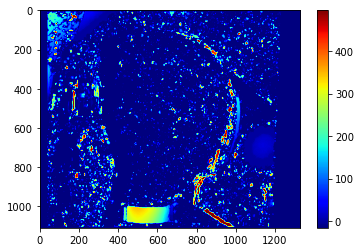

In [32]:
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
disparity_BM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_BM, aspect='equal', cmap='jet')
plt.colorbar()
plt.show()

In [33]:
import numpy as np

array = disparity_BM.copy()
array = array.flatten()
far_objects_rate = np.count_nonzero(array == min(array))/len(array)
close_objects_rate = np.count_nonzero(array == max(array))/len(array)
print('Доля наиболее отдаленных пикселей: ', far_objects_rate)
print('Доля наиболее близких пикселей: ', close_objects_rate)

Доля наиболее отдаленных пикселей:  0.8708284224073698
Доля наиболее близких пикселей:  0.011692745376955903


Для наглядности вывели карту глубин в цвете: ближние к камерам объекты красные, далее идет зеленый и синий.

Попробуем улучшить нашу карту и воспользуемся функцией StereoSGBM, у которой гораздо больше параметров, и которая позволяет искать в обе стороны (параметр minDisparity может быть отрицательным).

Р1, Р2 — параметры, контролирующие плавность диспаратности. Первый отвечает за изменение несоответствия на плюс или минус 1 между соседними пикселями, а второй отвечает за изменение несоответствия более чем на 1 между соседними пикселями. Алгоритм требует P2 > P1. Мы будем использовать следующие формулы для P1 и P2: 8 number_of_image_channels blockSize blockSize и 32 number_of_image_channels blockSize blockSize, соответственно.

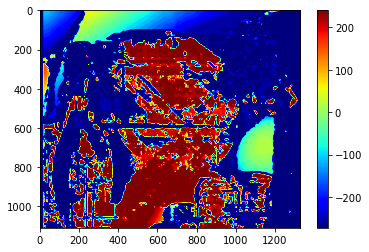

In [15]:
stereo = cv2.StereoSGBM_create(
    minDisparity=-16,
    numDisparities=32,
    blockSize=15,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * 15 ** 2,
    P2=32 * 3 * 15 ** 2,
)
disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_SGBM, aspect='equal', cmap='jet')
plt.colorbar()
plt.show()

In [17]:
array = disparity_SGBM.copy()
array = array.flatten()
far_objects_rate = np.count_nonzero(array == min(array))/len(array)
close_objects_rate = np.count_nonzero(array == max(array))/len(array)
print('Доля наиболее отдаленных пикселей: ', far_objects_rate)
print('Доля наиболее близких пикселей: ', close_objects_rate)

Доля наиболее отдаленных пикселей:  0.5302899139741245
Доля наиболее близких пикселей:  0.23412585517848675


Второй результат выглядит гораздо лучше.

Самостоятельно предлагается поменять параметры для лучшего понимания их назначения.